In [1]:
%matplotlib inline
# %load_ext autotime

import numpy as np
import pandas as pd
import sklearn
import pprint
import shap

import build_data, build_model, make_features_labels, plot_diagnostics, compute_metrics, save_load_model, build_nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import importlib as imp
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import experiment_settings
# Let's import some different things we will use to build the neural network
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Softmax
# import tensorflow_addons as tfa


dpiFig = 400
mpl.rcParams["figure.dpi"] = 100
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
plt.style.use("seaborn-white")

In [2]:
EXP_NAME = 'exp000'
SAVE_MODEL = True
SAVE_METRICS = True
#---------------------------------------------------------------
# setup the experiment you want to run in experiment_settings.py
settings = experiment_settings.get_settings(EXP_NAME)
settings

{'model_type': 'logistic_regression',
 'predictand': 'label_cyclogensis_boolean',
 'years': (1979, 2021),
 'storm_type': 'first_tropicalstorm',
 'len_rolling_sum': 7,
 'climo_nfilter': 41,
 'leadtimes': array([ 0,  7, 14, 21, 28, 35, 42, 49]),
 'n_val_years': 6,
 'months_to_predict': (5, 6, 7, 8, 9, 10, 11),
 'predictors_only_in_season': False,
 'show_plots': False,
 'rng_seed': 33,
 'warm_start': False,
 'class_weight': None,
 'lr_tol': 1e-06,
 'lr_max_iter': 1000,
 'exp_name': 'exp000'}

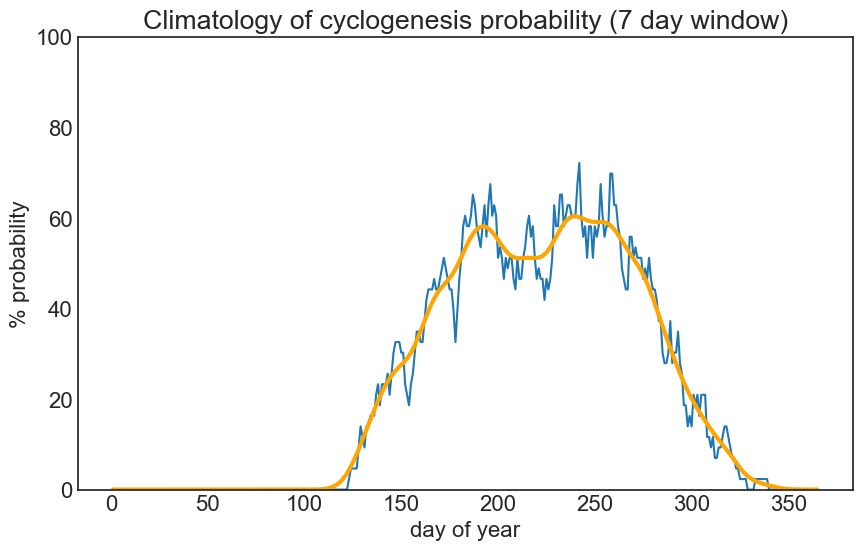

In [3]:
# build the data
df_data = build_data.build_data(settings)

In [4]:
# get year splits for validation
val_year_split = make_features_labels.get_val_years(settings, df_data)
# val_year_split = val_year_split[3:4]
pprint.pprint(val_year_split)

[array([1987, 1979, 2011, 1982, 1980, 2001, 2012]),
 array([2016, 1989, 2017, 2021, 2000, 1996]),
 array([1988, 2015, 2006, 1981, 1993, 2010]),
 array([1995, 1994, 2008, 2007, 1990, 1983]),
 array([2020, 2005, 2014, 2009, 1985, 2004]),
 array([2003, 2018, 1991, 2019, 1986, 1992]),
 array([1997, 1999, 1998, 1984, 2013, 2002])]


In [5]:
TEST_YEAR_ARR = [1979, 1983,1985,1992,1995,1996,1999,2010,2016,2018]

y_fold_arr = [0, 3, 4, 5, 3, 1, 6, 6, 2, 1, 5]

y_pos_arr = [1, 5, 4, 5, 0, 5, 1, 5, 0, 1]

In [6]:
# val_year = np.concatenate(val_year_split)

# val_year_new = np.where(val_year!=TEST_YEAR,val_year, np.nan)

# shuffled_years = val_year_new[~np.isnan(val_year_new)]

# val_year_split = np.array_split(shuffled_years, len(shuffled_years) / settings["n_val_years"])

# pprint.pprint(val_year_split)

In [7]:
pprint.pprint(val_year_split)

[array([1987, 1979, 2011, 1982, 1980, 2001, 2012]),
 array([2016, 1989, 2017, 2021, 2000, 1996]),
 array([1988, 2015, 2006, 1981, 1993, 2010]),
 array([1995, 1994, 2008, 2007, 1990, 1983]),
 array([2020, 2005, 2014, 2009, 1985, 2004]),
 array([2003, 2018, 1991, 2019, 1986, 1992]),
 array([1997, 1999, 1998, 1984, 2013, 2002])]


In [8]:
### Here is where we actually build the model

def compile_model():
  # This isn't good practice, but model will be a global variable
    global model

  # First we start with an input layer
    input_layer = Input(shape=x_train[0,:].shape) # size per sample, equal to number of features

  # Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
    layers = Dropout(0)(input_layer)

  # Now let's add a few layers. We are going to do two layers with 5 nodes each.
  # Each uses the 'relu' activation function and randomizes the initial weights/biases
  # Dropout may be useful for hidden layers if the number of hidden nodes is large
  # If Dropout(0), Dropout isn't being used.

    for hidden, activation in zip(HIDDENS, ACTIVATIONS):
        layers = Dense(hidden, activation=activation, bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)
    
        layers = Dropout(0)(layers)

  # Output layer has a softmax function to convert output to class likelihood
    output_layer = Dense(num_classes-1, activation='sigmoid', bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED), kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

  # Constructing the model
    model = Model(input_layer, output_layer)
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Using the Adam optimizer
    model.compile(optimizer=optimizer, loss=LOSS,metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.Accuracy(),tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives(),
                                                          tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(),tf.keras.metrics.Recall()]
                 )
  
 #     model.summary()


### This is the function that will iteratively train the model

def fit_model():
    global history
    
    history = model.fit(x_train, y_train, 
                        epochs=NUM_EPOCHS,verbose=VERBOSITY,batch_size = BATCH_SIZE, shuffle=True,
                        validation_data=[x_val, y_val],
                        class_weight = CLASS_WEIGHT, callbacks=[EARLY_STOPPING]
                       )

In [9]:
# This builds, compiles, then fits, the model. 
# It's important to recompile the model each time before fitting.

def train_model():
    compile_model()
    fit_model()

In [10]:
colors = ["#6c757d","#009969","#8b0053","#ff9c23","#00639a","#9359ba","#a0b2cd","#96bd52","#847149","#c45245"]

In [11]:
# TEST_YEAR = 2012

In [12]:
    bs_arr = []
    bss_arr = []
    bss_arr_enso = []
    bss_arr_rmm = []
    bss_arr_all_rmm = []
    bs_arr_baseline = []
    bss_arr_baseline = []
    bss_arr_all_rmm_rmm_7  = []
    bss_arr_all_rmm_rmm_7_sst = []
    bss_arr_all_rmm_rmm_7_uwind = []
    bss_arr_all_rmm_rmm_7_uwind_sst = []
    shaps = []
    shaps_all = []


    
    for leadtime in np.arange(0,7*8,7):
        print('---- leadtime ' + str(leadtime) + ' days ----')
        settings['leadtime'] = leadtime
        

        # REMEMBER TO INCLUDE BASELINE! IT NEEDS IT TO COMPUTE THE DIFFERENCES

        for features_type in ("baseline","enso","rmm","all_rmm","all_rmm_rmm-7","all_rmm_rmm-7_uwind_sst",
                             ):

            print(' ' + features_type)


            ### Here are some model architecture hyperparameters we can mess with

            SEED = 28980 # used for setting random values so results are reproducable

            HIDDENS = [14,7,7] # Number of hidden nodes in each layer of the model (list of ints)
            ACTIVATIONS = ['tanh'] * len(HIDDENS) # Activation function used in the hidden layers (list of strs)

            ### Here are some training options
            NUM_EPOCHS = 300 # Max number of times all of the data will be seen iteratively in training
            BATCH_SIZE = 7*10 # Number of samples
            VERBOSITY = 0 # 0: Silent during model.fit; 1: Progress bar; 2: Prints each epoch
            LEARNING_RATE = .001 # Learning rate (think step size)
            LOSS = 'binary_crossentropy' # Loss function
            #LOSS = tf.keras.losses.CategoricalHinge()

            ## Here we can change how much the loss function takes into consideration different classes
        #     CLASS_WEIGHT = {0 : len(y_train)/((len(y_train) - (sum(y_train))) * num_classes),
        #                     1 : len(y_train)/(((sum(y_train))) * num_classes),
        # ###                     2 : 1 / np.mean(Ttrain[:,2] == 1)
        #                    }

            CLASS_WEIGHT = {0 : 1, 1 : 1}

            ### Early Stopping
            EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                               patience=20,
                                                               verbose=1,
                                                               mode='auto',
                                                               restore_best_weights=True)

            # Setting a seed for tensorflow so results are reproducable
            try: # tensorflow 2
                tf.random.set_seed(SEED)
            except: # tf1
                tf.set_random_seed(SEED)

            metrics_dict = compute_metrics.declare_empty_metrics(len(val_year_split))

            for iterfold, val_years in enumerate(val_year_split):
                # get training/validation split
                settings["val_years"] = val_years
                df_data_model, df_data_train, df_data_val = make_features_labels.make_model_data(settings, df_data)

                # train the model
                x_train, y_train, x_val, y_val = make_features_labels.get_features_labels(settings,
                                                                                          features_type,
                                                                                          df_data_train,
                                                                                          df_data_val,
                                                                                          )


                num_classes = len(np.unique(y_train))
                # Training the model
                train_model()


                # make predictions with your model
                ypred_class = model.predict(x_val)
                ypred = np.argmax(ypred_class,axis=1)  # compute which class has the highest probability/likelihood
                y_pred = ypred_class[:,0]

                bs = np.mean((y_val-y_pred)**2)
                yref=np.ones(np.shape(y_val))*np.mean(y_train)
                bs_ref = np.mean((y_val-yref)**2)
                bss = 1. - bs/bs_ref

                pred = []

                if features_type == 'baseline':
                    bss_arr_baseline.append(bss)
                    bs_arr_baseline.append(bs)
                elif features_type == 'enso':
                    bss_arr_enso.append(bss)
                elif features_type == "rmm":
                    bss_arr_rmm.append(bss)
                elif features_type =="all_rmm":
                    bss_arr_all_rmm.append(bss)
                elif features_type ==  "all_rmm_rmm-7":
                    bss_arr_all_rmm_rmm_7.append(bss)
                elif features_type ==  "all_rmm_rmm-7_sst":
                    bss_arr_all_rmm_rmm_7_sst.append(bss)
                elif features_type == 'all_rmm_rmm-7_uwind':
                    bss_arr_all_rmm_rmm_7_uwind.append(bss)
                elif features_type == "all_rmm_rmm-7_uwind_sst":
                    bss_arr_all_rmm_rmm_7_uwind_sst.append(bss)
                else:
                    bss_arr.append(bss)
                    bs_arr.append(bs)

---- leadtime 0 days ----
 baseline
Restoring model weights from the end of the best epoch: 128.
Epoch 148: early stopping
47/47 [==============================] - 0s 435us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 23: early stopping
41/41 [==============================] - 0s 473us/step
Restoring model weights from the end of the best epoch: 31.
Epoch 51: early stopping
41/41 [==============================] - 0s 463us/step
Restoring model weights from the end of the best epoch: 59.
Epoch 79: early stopping
41/41 [==============================] - 0s 463us/step
Restoring model weights from the end of the best epoch: 3.
Epoch 23: early stopping
41/41 [==============================] - 0s 459us/step
Restoring model weights from the end of the best epoch: 53.
Epoch 73: early stopping
41/41 [==============================] - 0s 458us/step
Restoring model weights from the end of the best epoch: 107.
Epoch 127: early stopping
41/41 [==============================